In [1]:
# ---------CASO C1: Vuelo rectilíneo y simétrico: T cte y V variable y pequeña-----------
# --------- integrador de solve_ivp
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones   

Lo que sindy en realidad está viendo:
$$
U_\infty \hat{\dot{V}} = -AU_\infty^2\hat{V}^2 + C - \frac{B}{\hat{V}^2*U_\infty^2}\\
\hat{\dot{V}} = -AU_\infty\hat{V}^2 + \frac{C}{U_\infty} - \frac{B}{\hat{V}^2*U_\infty^3}\\
A = \frac{1}{2} \rho_{aire} \frac{S}{m} C_{D0} \\
B = k \frac{g^2}{\frac{1}{2} \rho_{aire} \frac{S}{m}}\\
C = \frac{T}{m} \\
Sindy\hspace{0.1cm} calcula:
a = AU_\infty \\
b = \frac{B}{U_\infty^3}\\
c = \frac{C}{U_\infty}\\
\hat{\dot{V}} = -a\hat{V}^2 + c - \frac{b}{\hat{V}^2}\\
$$


## Variables globales

In [2]:
# definicion de parametros fisicos y aerondinamicos del cohete
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
vmax = 6

#multiplico por 10 porque si no es un valor tan pequeño que en comparacion con B no lo va a obtener
A = 0.5*1.225*cd0*S/m*10
B = k*9.81**2/(0.5*1.225*S/m)
# Este es el coeficiete C, en realidad es T/m
T0 = 7
print(f"Valor de los coeficientes: A={A}, B={B}, C={T0}")

Valor de los coeficientes: A=0.013505625, B=156.0513186172428, C=7


In [3]:
#definición de las variables generales
n = 100000
deltat = 0.00001
""" t = np.zeros(n)
for i in range(0, n):
    t[i] = deltat*i

print(t.shape[0], t) """
t = np.arange(0, int(n*deltat), deltat)

N_SIMS = 12


## Funciones

In [4]:
def plot_ntraj(n_trayec, error):
    plt.figure(figsize=(8,6))
    plt.title("Análisis número de trayectorias")
    plt.xlabel('Número de trayectorias')
    plt.ylabel('Error medio de cada simulación por trayectoria')
    error2 = np.mean(error, axis=2)
    plt.semilogy(n_trayec, np.median(error2, axis=0))
    #plt.semilogy(n_trayec, np.median(np.median(error, axis=2), axis=0))

In [5]:
def plot_error_vs_tiempo(t, error, trayecs):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Mediana del error')

    for i, n in enumerate(trayecs):
        plt.plot(t, np.median(error[:, i, :], axis=0), label=str(n) + ' trayec')
    plt.legend()

In [6]:
def plot_error_vs_tiempo_val(t, error, n_trayec):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria medio")
    plt.xlabel('Tiempo de validacion(s)')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        #print(len(np.median(error, axis=0).squeeze()))
        plt.plot(t, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [7]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error según pot ruido")
    plt.xlabel('Pot ruido')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        plt.loglog(pots, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [8]:
def plot_precision_tiempo(error, muestras, tiempos):
    fig = plt.figure(figsize=(8,6))
    T, M = np.meshgrid(tiempos, muestras)
    
    error2 = error.mean(axis=0)
    
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    print(error2.shape)
    print(M.shape, T.shape)
    ax.plot_surface(T, M, error2, cmap="coolwarm")
    ax.set_xlabel('Tiempo máximo de entrenamiento')
    ax.set_ylabel('Número de muestras')
    ax.set_zlabel('Error cuadrático medio')

## Generar gráficas

v = -0.117 v^2 + -0.290 1/v^2 + 0.868 1


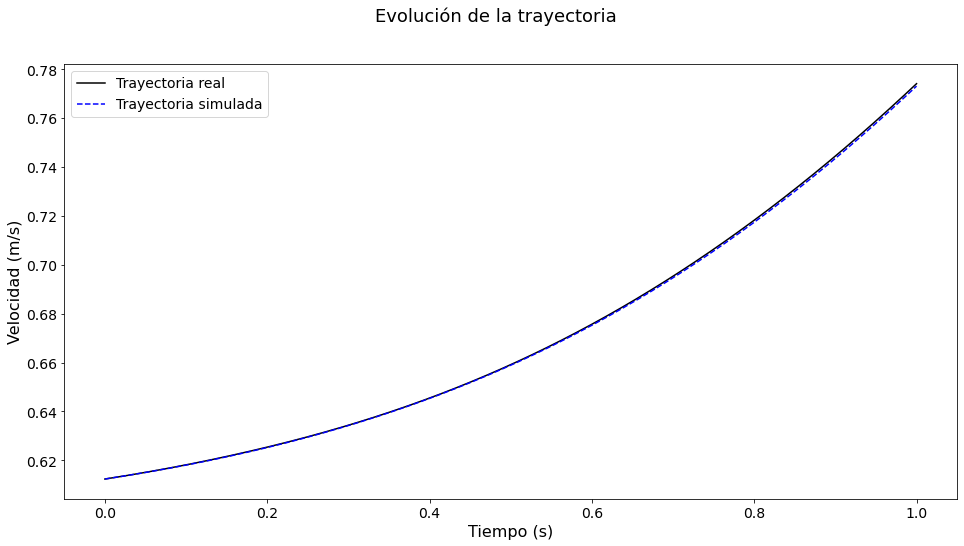

In [13]:
#numero de trayectorias vs error
# sin introducir restricciones
n_trayectorias_test = [2,4,8, 25]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayectorias_test[i], t, [T0, A, B], v0, 
                mod=utils.Model_params(feature_list=['v'], lib=utils.custom_ecs_B()))
        error[j,i] = mod.error_trayec(t)[:, 0]

    if n_trayectorias_test[i] == 25:
        mod.plot_trayec(t)
        model25 = mod.model_sindy
model25.print(lhs=["v'"])



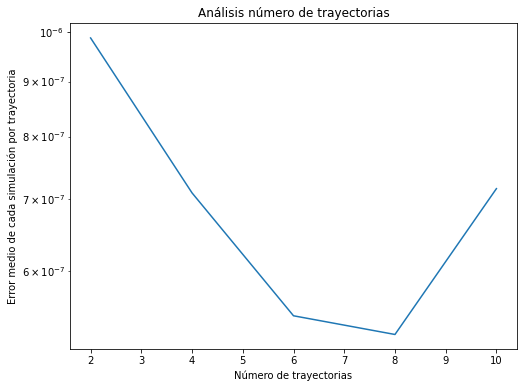

In [9]:
#numero de trayectorias vs error
# sin introducir restricciones
n_trayectorias_test = [2,4,6,8,10]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayectorias_test[i], t, [T0, A, B], v0)
        error[j,i] = mod.error_trayec(t)[:, 0]

# Representar
plot_ntraj(n_trayectorias_test, error)


In [10]:
n_trayectorias_test = [2,4,6,7,8,10,15,17,20]
n_sims = 20
v0 = 5

t2 = np.arange(0, int(n*3*deltat), deltat)

error2 = np.zeros((n_sims, len(n_trayectorias_test), t2.shape[0]))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayectorias_test[i], t2, [T0, A, B], v0)
        error2[j,i] = mod.error_trayec(t2)[:, 0]


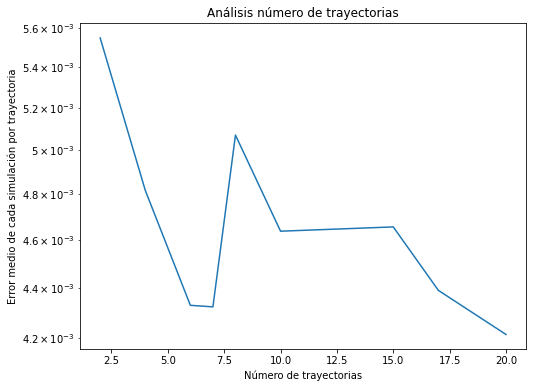

In [11]:
# Representar
plot_ntraj(n_trayectorias_test, error2)

trayectoria: 1
trayectoria: 2
trayectoria: 3
trayectoria: 5
trayectoria: 15
trayectoria: 25


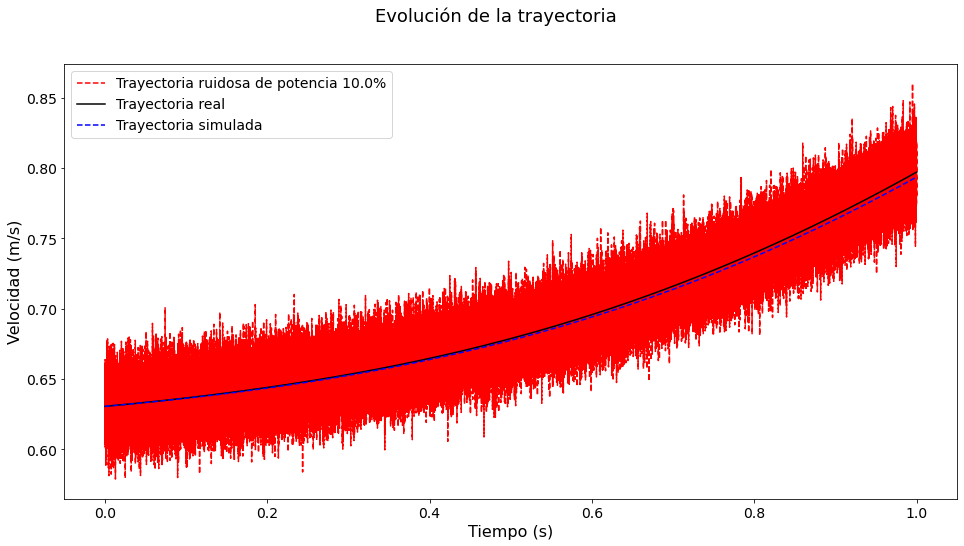

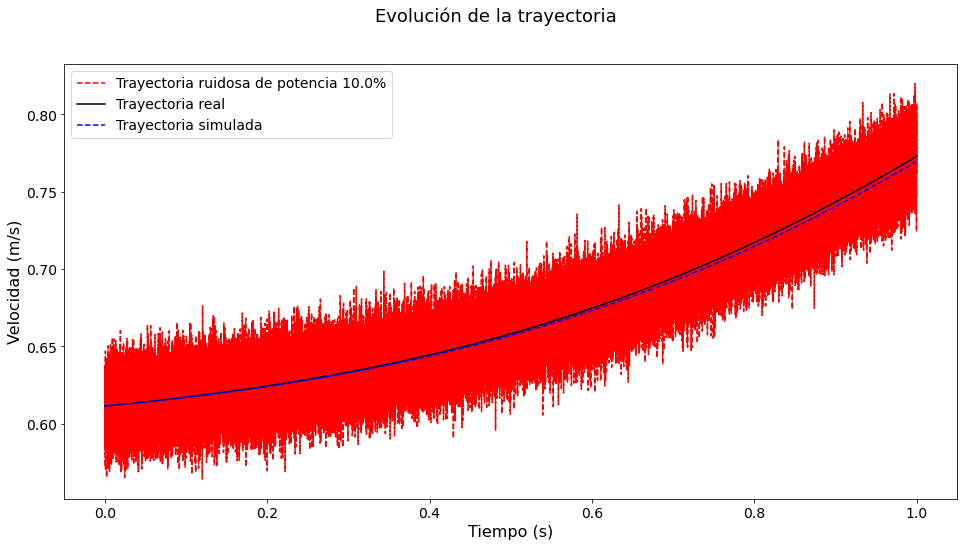

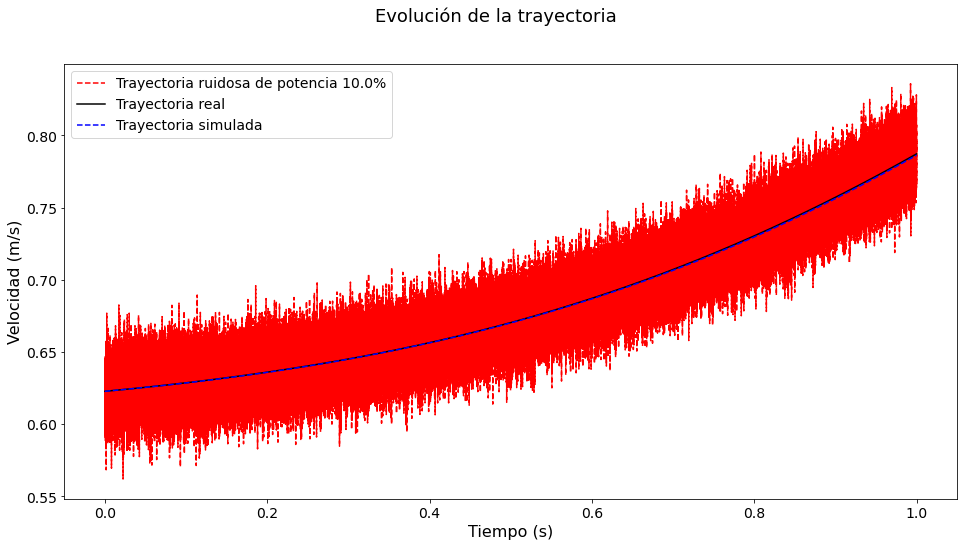

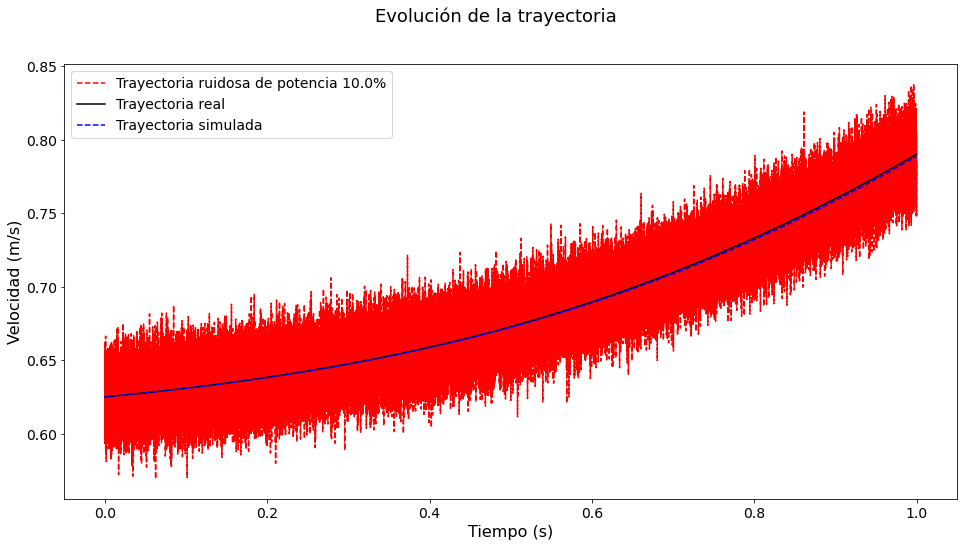

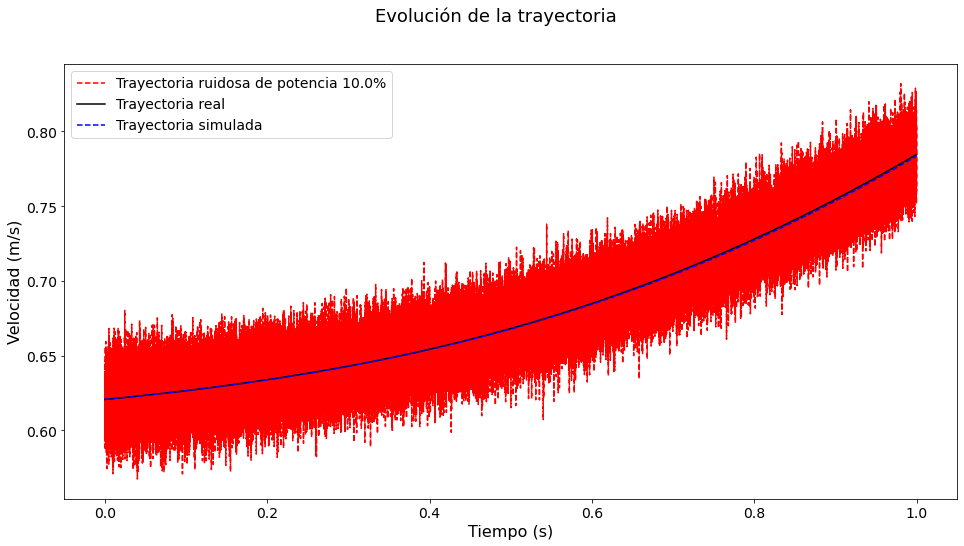

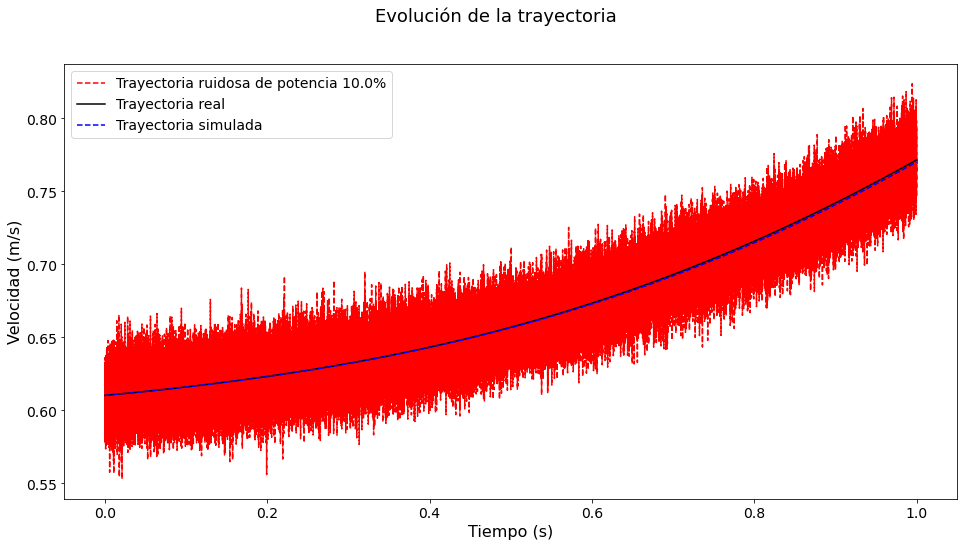

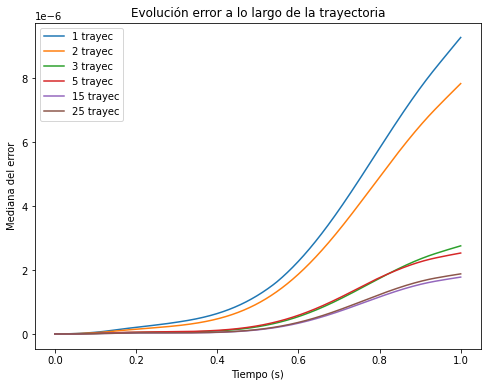

In [17]:
# represento la evoucion del error con el tiempo
n_trayectorias_test = [1, 2, 3, 5, 15, 25]
n_sims = N_SIMS
lent = t.shape[0]
v0 = 5

# t vs error en cada punto
error3 = np.zeros((n_sims, len(n_trayectorias_test), lent)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayectorias_test[i], t, [T0, A, B], v0)
        error3[j,i] = mod.error_trayec(t)[:, 0]
    print("trayectoria: "+ str(n_trayectorias_test[i]))
    mod.plot_trayec(t, plot_data_ruidosa=True, ruido=1e-1)
        
 
# Representar
plot_error_vs_tiempo(t, error3, n_trayectorias_test)

(array([-1.e-06,  0.e+00,  1.e-06,  2.e-06,  3.e-06,  4.e-06,  5.e-06,
         6.e-06,  7.e-06,  8.e-06,  9.e-06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

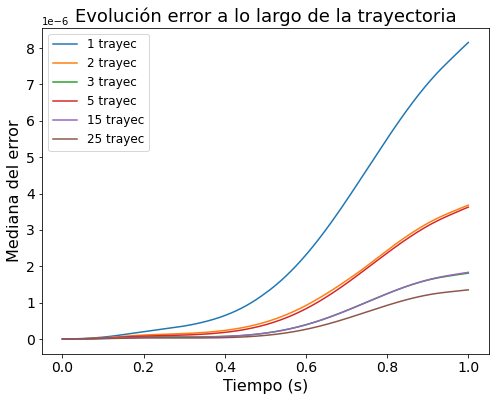

In [17]:
plt.figure(figsize=(8,6))
plt.title("Evolución error a lo largo de la trayectoria", fontsize=18)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Mediana del error', fontsize=16)

for i, n in enumerate(n_trayectorias_test):
    plt.plot(t, np.median(error3[:, i, :], axis=0), label=str(n) + ' trayec')
plt.legend(fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [19]:
# entreno con t y calculo el error para tiempos mas grandes
n_trayec = [10, 20, 30, 40]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error4 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC1, n_trayec[i], t, [T0, A, B], v0, t_val=t_val)
            error4[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



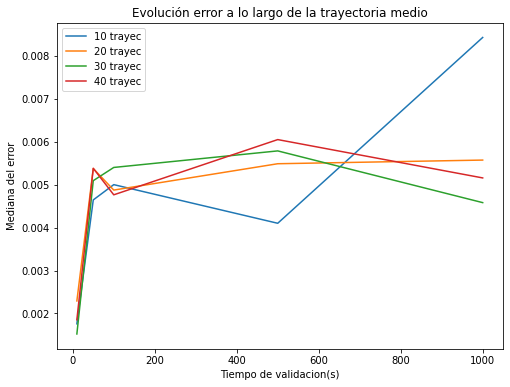

In [25]:
# Representar tiempo de val vs error
plot_error_vs_tiempo_val(tiempos_val, error, n_trayec)

In [11]:

# obtengo el error con ruido en las muestras EJECUTAR
n_trayec = [10, 15]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error5 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC1, n_trayec[i], t, [T0, A, B], v0, t_val=t_val, ruido=0.001)
            error5[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



/home/mdiaz/TFGAero/utils.py:212: RuntimeWarning: overflow encountered in square
  lambda v : v**2,
/home/mdiaz/TFGAero/utils.py:213: RuntimeWarning: overflow encountered in square
  lambda v: 1/v**2,


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

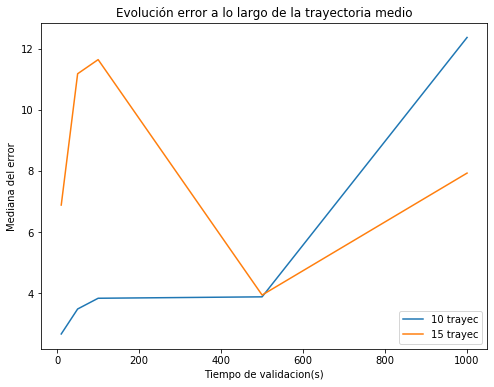

In [ ]:
# Representar tiempo de val vs error con ruido EJECUTAR
plot_error_vs_tiempo_val(tiempos_val, error5, n_trayec)

In [ ]:
# obtengo el error con ruido en las muestras de train EJECUTAR
n_trayec = [5, 10, 15]
n_sims = 20
v0 = 5
# t_train vs error en cada punto
error6 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayec[i], t, [T0, A, B], v0, ruido=0.001)
        error6[j,i] = mod.error_trayec(t)[:, 0]
            
# Representar tiempo de val vs error con ruido  
plot_error_vs_tiempo(t, error6, n_trayec)

KeyboardInterrupt: 

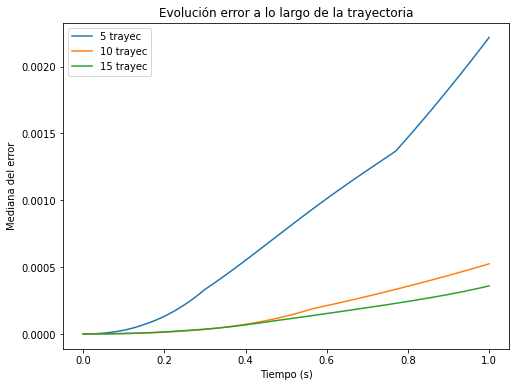

In [ ]:
# obtengo el error con ruido en las muestras EJECUTAR
n_trayec = [5, 10, 15]
n_sims = N_SIMS
v0 = 5
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC1, n_trayec[i], t, [T0, A, B], v0, ruido=0.003)
        error7[j,i,:] = mod.error_trayec(t)[: ,0]
            
# Representar tiempo de val vs error con ruido 
plot_error_vs_tiempo(t, error7, n_trayec)

Trayectoria: 5
Trayectoria: 10
Trayectoria: 20
Trayectoria: 40
Trayectoria: 50


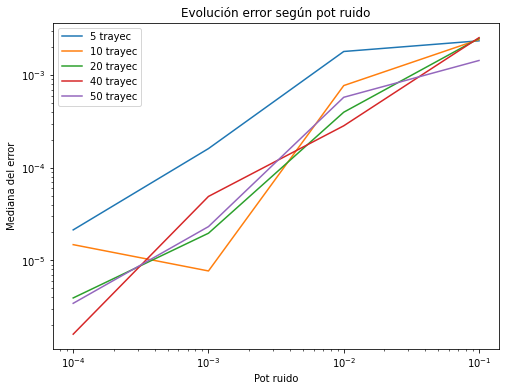

In [38]:
# error vs potencia de ruido en las muestras
n_trayec = [5, 10, 20, 40, 50]
n_sims = N_SIMS
v0 = 5
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]
# t_train vs error en cada punto
error8 = np.zeros((n_sims, len(n_trayec), len(pots_ruido)))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod = utils.Model()
            mod.eval(utils.casoC1, n_trayec[i], t, [T0, A, B], v0, ruido=pots_ruido[z])
            error8[j,i,z] = mod.error_trayec(t)[:, 0].mean()
    print("Trayectoria: "+ str(n_trayec[i]))
            
# Representar tiempo de val vs error con ruido
plot_error_vs_pot_ruido(error8, n_trayec, pots_ruido)

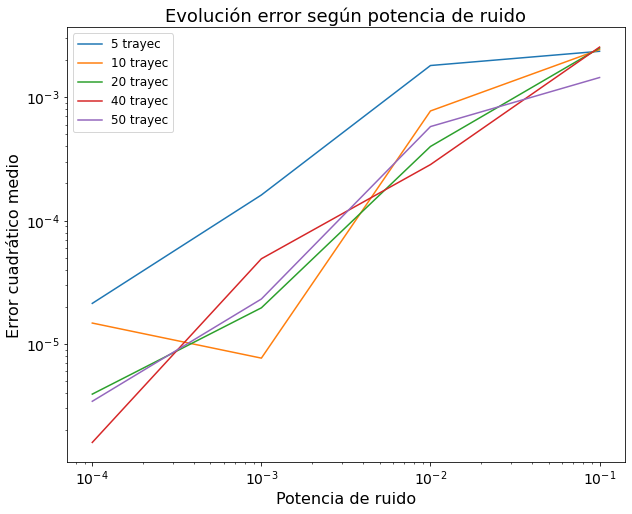

In [39]:
plt.figure(figsize=(10,8))
plt.title("Evolución error según potencia de ruido", fontsize=18)
plt.xlabel('Potencia de ruido', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
error8_1 = np.median(error8, axis=0)
for trayec, i in zip(n_trayec, range(len(n_trayec))):
    plt.loglog(pots_ruido, error8_1[i, :], label=str(trayec)+ ' trayec')
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

In [13]:
# calculo el error según el tamaño de t de train y el numero de muestras EJECUTAR
trayec = 20 
n_sims = N_SIMS
tiempos_train = [10, 50, 100, 500, 1000]
muestras = [10**4, 10**5, 10**6]
v0 = 5
# t_train vs error en cada punto
error9 = np.zeros((n_sims, len(muestras), len(tiempos_train))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(muestras)):
    for z in range(len(tiempos_train)):
        t_train = np.arange(0, tiempos_train[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC1, trayec, t_train, [T0, A, B], v0)
            error9[j,i,z] = mod.error_trayec(t_train)[:, 0].mean()

In [ ]:
plot_precision_tiempo(error9, muestras, tiempos_train)

NameError: name 'error9' is not defined

In [10]:
def real_coefs_mat(real_coefs, lib):
    data = [np.ones((n, 1))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('1/v^2')] = real_coefs[1]
    mat[0, list_names.index('1')] = real_coefs[2]

    return mat


In [11]:
def otra_libreria():
    library_functions = [
        lambda v: 1/v**2,
    ]
    library_function_names = [
        lambda v: '1/' + v + "^2", 
    ]
    library = ps.CustomLibrary(library_functions=library_functions, 
                                function_names=library_function_names,
                              interaction_only=True) + ps.PolynomialLibrary(degree=5)
    return library

In [16]:
# error en los coeficientes según el número de trayectorias, para librería de grado 5 + 1/v^2
n_trayectorias_test = [2,4,6,8,10,13, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error10 = np.zeros((n_sims, len(n_trayectorias_test)))
error11 = np.zeros((n_sims, len(n_trayectorias_test)))

for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0,
                mod=utils.Model_params(lib=otra_libreria()))
        real_coefs = np.array([-A*mod.maxi, -B/mod.maxi**3, T0/mod.maxi])
        mat_real = real_coefs_mat(real_coefs, otra_libreria())
        error10[j, i] = np.mean(mod.error_coefs(mat_real)**2)
        error11[j,i] = mod.error_trayec(t).mean(axis=0)


/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdia

In [17]:
real_coefs

array([[-0.2394576 ],
       [-0.02799791],
       [ 0.39480632]])

[122.67404433 172.22216102 212.79638692 342.94441606 359.2344349
 384.94895164 374.6215706  386.6426394 ]


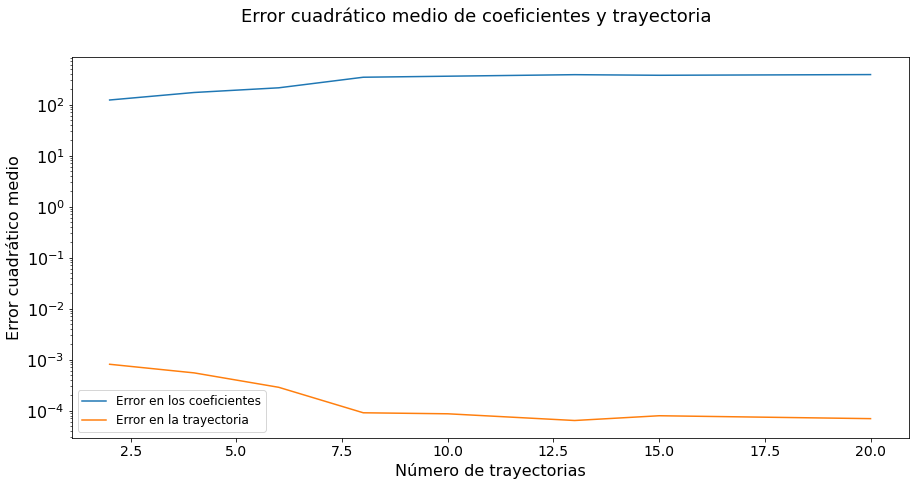

In [23]:
print(np.median(error10, axis=0))
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Error cuadrático medio de coeficientes y trayectoria', fontsize=18)

#print(len(n_trayectorias_test), np.median(error10, axis=0).shape)
plt.semilogy(n_trayectorias_test, np.median(error10, axis=0), label='Error en los coeficientes')
plt.semilogy(n_trayectorias_test, np.median(error11, axis=0), label='Error en la trayectoria')
plt.xlabel('Número de trayectorias', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
plt.xticks(fontsize=14) #n_trayectorias_test, [str(x) for x in n_trayectorias_test], 
plt.yticks(fontsize=16)
plt.legend(fontsize=12)

In [11]:
# error vs potencia de ruido en las muestras

n_trayectorias_test = [5, 10, 25]
n_sims = N_SIMS
v0 = 5
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]

error12 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido)))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod = utils.Model()
            mod.eval(utils.casoC1, n_trayectorias_test[i], t, [T0, A, B], v0, ruido=pots_ruido[z])
            real_coefs = np.array([-A*mod.maxi, -B/mod.maxi**3, T0/mod.maxi])
            mat_real = real_coefs_mat(real_coefs, utils.custom_ecs_B())
            error12[j,i, z] = np.mean(mod.error_coefs(real_coefs.T)**2)

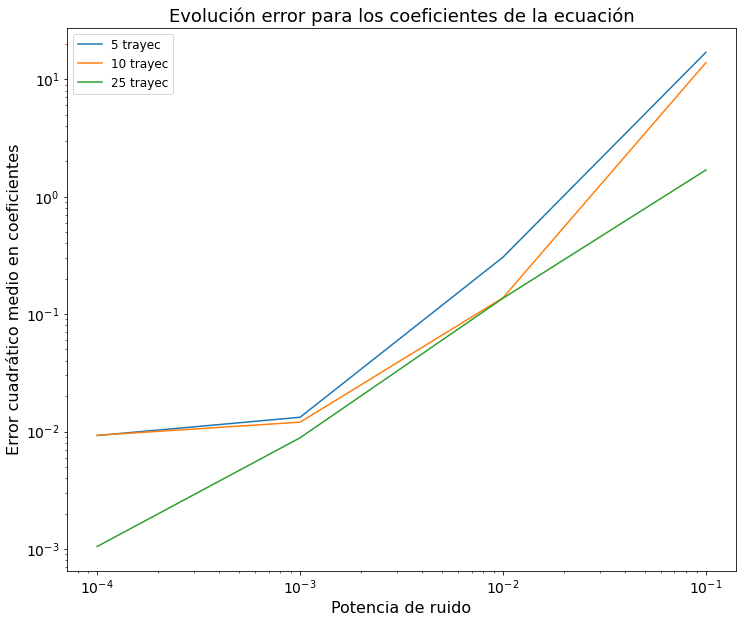

In [13]:
plt.figure(figsize=(12,10))
plt.title("Evolución error para los coeficientes de la ecuación", fontsize=18)
plt.xlabel('Potencia de ruido', fontsize=16)
plt.ylabel('Error cuadrático medio en coeficientes', fontsize=16)
error12_1 = np.median(error12, axis=0)
for trayec, i in zip(n_trayectorias_test, range(len(n_trayectorias_test))):
    plt.loglog(pots_ruido, error12_1[i, :], label=str(trayec)+ ' trayec')
    
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)